In [1]:
from osgeo import ogr
import os
import geopandas as gpd
import matplotlib.pyplot as plt
import fiona
import sys
import rasterio as rio
import numpy as np

# import the vertical interpolation functionality
sys.path.append('../preprocess_sm')
from utils import vert_interp

gdb_path = os.path.join(
    os.environ['PROJDIR'], 'DATA', 'Soil_Properties', 'gNATSGO_CONUS', 'gNATSGO_CONUS.gdb'
)

# The top 10 layers in ELM are hydrologically active
# here are the layers' interface depths, unit: m
layer_depth = [0, 0.0175, 0.0451, 0.0906, 0.1655, 0.2891, 0.4929, 0.8289, 1.3828, 2.2961, 3.8019]

In [2]:
##########################################################################
# Use gdal to check the layers in the gNATSGO database
# 
# In SSURGO data, the field “mukey” uniquely identifies a map unit, and the field 
# “cokey” uniquely identifies a map unit component.
##########################################################################
driver = ogr.GetDriverByName("OpenFileGDB")
gdb = driver.Open(gdb_path, 0)

if gdb is None:
    print(f"Error: Could not open {gdb_path}")

layer_count = gdb.GetLayerCount()
print(f"Total layers: {layer_count}")

layer_summary = {}

for idx in range(layer_count):
    layer = gdb.GetLayerByIndex(idx)
    layer_name = layer.GetName()
    feature_count = layer.GetFeatureCount()

    print(f"\nLayer: {layer_name}")
    print(f"Feature count: {feature_count}")

    layer_summary[layer_name] = feature_count

    """
    # Get layer definition
    layer_def = layer.GetLayerDefn()
    field_count = layer_def.GetFieldCount()

    print("Fields:")
    for field_idx in range(field_count):
        field_def = layer_def.GetFieldDefn(field_idx)
        print(f"  {field_def.GetName()} - {field_def.GetTypeName()}")

    # Optional: Print first feature attributes
    if feature_count > 0:
        feature = layer.GetNextFeature()
        print("\nFirst feature attributes:")
        for field_idx in range(field_count):
            field_def = layer_def.GetFieldDefn(field_idx)
            print(f"  {field_def.GetName()}: {feature.GetField(field_idx)}")
    """

gdb = None  # Close the connection

Total layers: 71

Layer: chaashto
Feature count: 5883563

Layer: chconsistence
Feature count: 707698

Layer: chdesgnsuffix
Feature count: 1896285

Layer: chfrags
Feature count: 6114802

Layer: chorizon
Feature count: 3563608

Layer: chpores
Feature count: 234680

Layer: chstruct
Feature count: 3382144

Layer: chstructgrp
Feature count: 2756655

Layer: chtext
Feature count: 165456

Layer: chtexture
Feature count: 7635939

Layer: chtexturegrp
Feature count: 7509709

Layer: chtexturemod
Feature count: 2314523

Layer: chunified
Feature count: 6418310

Layer: cocanopycover
Feature count: 293665

Layer: cocropyld
Feature count: 1945606

Layer: codiagfeatures
Feature count: 1180850

Layer: coecoclass
Feature count: 1160589

Layer: coeplants
Feature count: 4351071

Layer: coerosionacc
Feature count: 210715

Layer: coforprod
Feature count: 1550450

Layer: coforprodo
Feature count: 16619

Layer: cogeomordesc
Feature count: 2089273

Layer: cohydriccriteria
Feature count: 261267

Layer: cointerp
F

<AxesSubplot:>

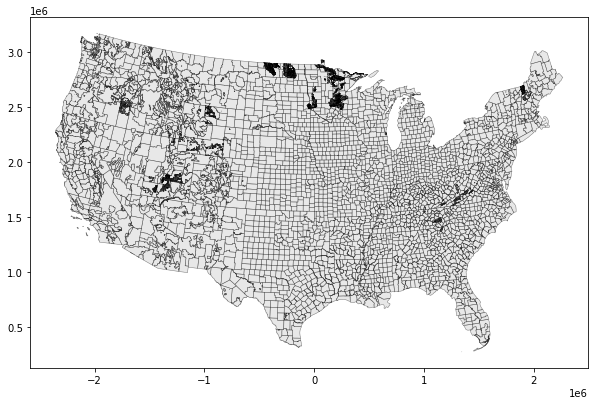

In [8]:
# Plot the spatial distribution of the LKEY level of spatial units
gdf = gpd.read_file(gdb_path, layer='SAPOLYGON')

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the geometry
gdf.geometry.plot(
    ax=ax,
    edgecolor='black',
    facecolor='lightgray',
    alpha=0.5,
    linewidth=0.5
)

gdf = None

In [3]:
############################################################
# Relationship between lkey (the SAPOLYGON)
# and mukey (mapunit key)
#
# Each SAPOLYGON contains many map units, each map unit
# contain multiple components, which may be vertial horizons
############################################################
gdf = gpd.read_file(gdb_path, layer='mapunit')
mukey_lkey = gdf[['mukey', 'lkey']]

In [22]:
############################################################
# Relationship between cokey ("components" inside map unit)
# and mukey (mapunit key)
############################################################
mukey_cokey = gpd.read_file(gdb_path, layer='component')
mukey_cokey = mukey_cokey[['comppct_r','mukey','cokey']]

In [9]:
############################################################
# Tables of interest
# 
# Explanations of the individual table columns' names are in:
# - SSURGO-Metadata-Table-Column-Descriptions-Report.pdf 
#   https://www.nrcs.usda.gov/sites/default/files/2022-08/SSURGO-Metadata-Table-Column-Descriptions-Report.pdf
#
# Explanations of the table columns' units are in: 
# - SSURGO-Metadata-Tables-and-Columns-Report.pdf
#   https://www.nrcs.usda.gov/sites/default/files/2022-08/SSURGO-Metadata-Tables-and-Columns-Report.pdf
#
# The relevant tables and columns are: 
# 
# chorizon
# - sand (% weight): sandtotal_r
# - silt (% weight): silttotal_r
# - clay (% weight): claytotal_r
# - organic matter (% weight): om_r
# - hydraulic conductivity (um/s): ksat_r
# - the distance from the top of the soil to the 
#   upper boundary of the soil horizon (cm): hzdept_r
# - .............................................
#   lower boundary ................... (cm): hzdepb_r
#
# muaggatt
# - soil depth (cm): brockdepmin
#
# chfrags
# - gravel (% volume): fragvol_r
# 
# Process in chunks because the whole database is too large
############################################################
def read_gNATSGO(path, table, mukey_list):
    # Use fiona to get the records
    with fiona.open(path, layer = table) as src:
        crs = src.crs

        records = []
        for i, feat in enumerate(src):
            if i >= row_start:
                if i < (row_start + chunck_size):
                    records.append(feat)
                else:
                    break

        gdf_chunk = gpd.GeoDataFrame.from_features(records, crs = crs)
    return gdf_chunk

In [ ]:
src = fiona.open(gdb_path, layer = 'chorizon')
for i, feat in enumerate(src):
    break

In [ ]:
dst_dir = os.path.join(os.environ['PROJDIR'], 'Soil_Moisture_v2', 
                       'intermediate', 'map_predictors', 'gNATSGO')

layer_name = 'chorizon'
col_key = ['hzdept_r', 'hzdepb_r', 'cokey']
col_list = ['sandtotal_r', 'silttotal_r', 'claytotal_r', 'om_r', 'ksat_r']
mukey_piece = 1 # 1-12

# Get the list of mukeys in this piece
with rio.open(os.path.join(dst_dir, f'mukey_grid_{mukey_piece}.tif')) as src:
    mukey_map = src.read(1, masked = True)

mukey_list = np.unique(mukey_map)
if mukey_list[0] == 0:
    mukey_list = mukey_list[1:]

chorizon_chunk = read_gNATSGO(gdb_path, layer_name, mukey_list)
chorizon_chunk = chorizon_chunk[col_list + col_key]

# -----------------------------------------------------
# for each component key (cokey), interpolate the soil
# horizons to ELM depth
# -----------------------------------------------------
# check the deepest depth
chorizon_chunk[['hzdept_r','hzdepb_r']].hist()

In [ ]:
layer_name = 'muaggatt'
col_key = ['hzdept_r', 'hzdepb_r', 'cokey']
col_list = ['sandtotal_r', 'silttotal_r', 'claytotal_r', 'om_r', 'ksat_r']
chunksize = 100

#for rowstart in range(0, layer_summary[layer], chunksize):
rowstart = 0
chorizon_chunk = read_gNATSGO(gdb_path, layer_name, chunksize, rowstart)
chorizon_chunk = chorizon_chunk[col_list + col_key]
